In [9]:
import pandas as pd

dataset = pd.read_csv("lung_cancer_dataset.csv")

# Convert text to categorical data
dataset['gender'] = dataset['gender'].astype('category')
dataset['radon_exposure'] = dataset['radon_exposure'].astype('category')
dataset['alcohol_consumption'] = dataset['alcohol_consumption'].fillna('None').astype('category')

dataset['asbestos_exposure'] = dataset['asbestos_exposure'].map({'Yes': True, 'No': False})
dataset['secondhand_smoke_exposure'] = dataset['secondhand_smoke_exposure'].map({'Yes': True, 'No': False})
dataset['copd_diagnosis'] = dataset['copd_diagnosis'].map({'Yes': True, 'No': False})
dataset['family_history'] = dataset['family_history'].map({'Yes': True, 'No': False})
dataset['lung_cancer'] = dataset['lung_cancer'].map({'Yes': True, 'No': False})

# show data
dataset.head()

,patient_id,age,gender,pack_years,radon_exposure,asbestos_exposure,secondhand_smoke_exposure,copd_diagnosis,alcohol_consumption,family_history,lung_cancer
0,100000,69,Male,66.025244,High,False,False,True,Moderate,False,False
1,100001,32,Female,12.780800,High,False,True,True,Moderate,True,True
2,100002,89,Female,0.408278,Medium,True,True,True,None,False,True
3,100003,78,Female,44.065232,Low,False,True,False,Moderate,False,True
4,100004,38,Female,44.432440,Medium,True,False,True,None,True,True


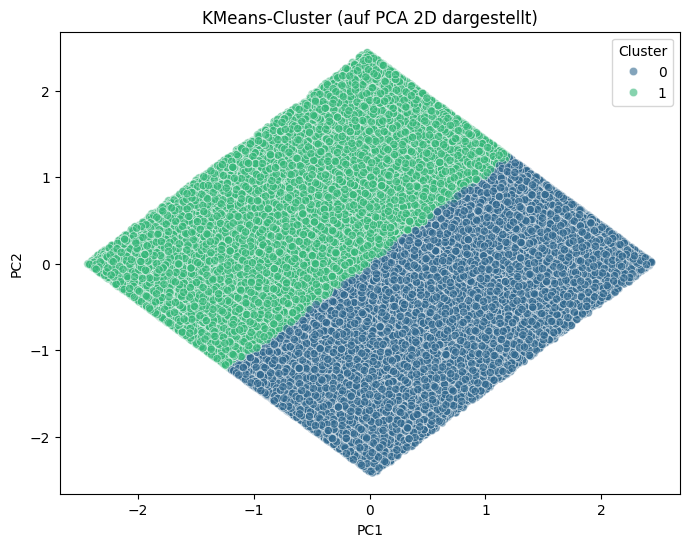

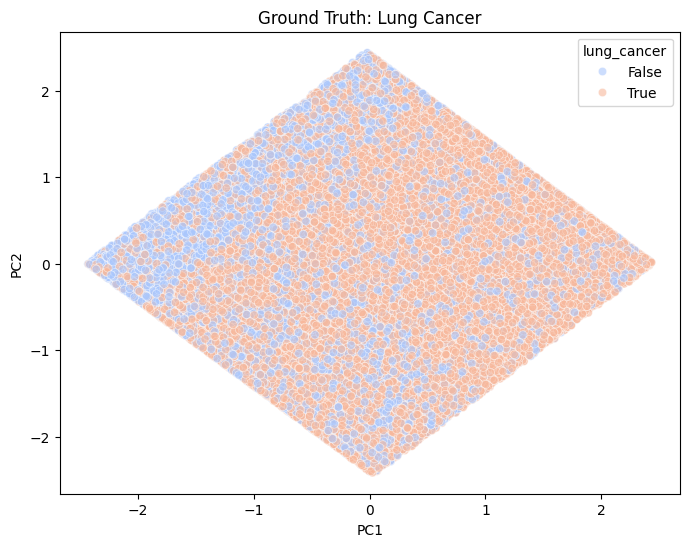

In [10]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Numerische und kategoriale Spalten trennen
numeric_features = ['age', 'pack_years']
categorical_features = ['gender', 'radon_exposure', 'alcohol_consumption']
boolean_features = ['asbestos_exposure', 'secondhand_smoke_exposure',
                    'copd_diagnosis', 'family_history']

# Preprocessing definieren
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features),
        ('bool', 'passthrough', boolean_features)
    ])

# Daten vorbereiten (Zielvariable 'lung_cancer' nicht nutzen!)
X = dataset.drop('lung_cancer', axis=1)
y = dataset['lung_cancer']

# --- Vorverarbeitete Daten ---
X_preproc = preprocessor.fit_transform(X)

# --- KMeans Clustering ---
kmeans = KMeans(n_clusters=2, random_state=42)  # hier 2 Cluster, weil du auch 2 Klassen hast
clusters = kmeans.fit_predict(X_preproc)

# --- DataFrame für Plot ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_preproc)
kmeans_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
kmeans_df['Cluster'] = clusters
kmeans_df['lung_cancer'] = y.values

# --- Plot: KMeans-Cluster im PCA-Raum ---
plt.figure(figsize=(8,6))
sns.scatterplot(data=kmeans_df, x='PC1', y='PC2',
                hue='Cluster', palette='viridis', alpha=0.6)
plt.title("KMeans-Cluster (auf PCA 2D dargestellt)")
plt.show()

# --- Vergleich mit Ground Truth ---
plt.figure(figsize=(8,6))
sns.scatterplot(data=kmeans_df, x='PC1', y='PC2',
                hue='lung_cancer', palette='coolwarm', alpha=0.6)
plt.title("Ground Truth: Lung Cancer")
plt.show()

In [13]:
from sklearn.metrics import accuracy_score, adjusted_rand_score, silhouette_score
import numpy as np

# KMeans Cluster
clusters = kmeans.fit_predict(X_preproc)

# --- Accuracy (nur nach Umbenennung sinnvoll) ---
# Clusterlabels sind willkürlich, wir prüfen beide Möglichkeiten
acc1 = accuracy_score(y, clusters)
acc2 = accuracy_score(y, 1 - clusters)  # Labels flippen
accuracy = max(acc1, acc2)

# --- Adjusted Rand Index (ARI) ---
# misst Ähnlichkeit der Clusterstruktur mit den echten Labels (0 = Zufall, 1 = perfekt)
ari = adjusted_rand_score(y, clusters)

# --- Silhouette Score ---
# misst wie gut Cluster trennbar und kompakt sind (-1 = schlecht, +1 = perfekt)
silhouette = silhouette_score(X_preproc, clusters)

print(f"Accuracy: {accuracy:.3f}")
print(f"Adjusted Rand Index: {ari:.3f}")
print(f"Silhouette Score: {silhouette:.3f}")

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

sil_score = silhouette_score(X_preproc, clusters)
ch_score = calinski_harabasz_score(X_preproc, clusters)
db_score = davies_bouldin_score(X_preproc, clusters)

print(f"Silhouette Score: {sil_score:.3f}")
print(f"Calinski-Harabasz Score: {ch_score:.3f}")
print(f"Davies-Bouldin Score: {db_score:.3f}")

from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

ari = adjusted_rand_score(y, clusters)
ami = adjusted_mutual_info_score(y, clusters)

print(f"Adjusted Rand Index: {ari:.3f}")
print(f"Adjusted Mutual Info: {ami:.3f}")


Accuracy: 0.573
Adjusted Rand Index: 0.021
Silhouette Score: 0.164
Silhouette Score: 0.164
Calinski-Harabasz Score: 11083.113
Davies-Bouldin Score: 2.104
Adjusted Rand Index: 0.021
Adjusted Mutual Info: 0.018


In [ ]:
inertia = []
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42).fit(X_preproc)
    inertia.append(km.inertia_)

plt.plot(range(2,10), inertia, 'o-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

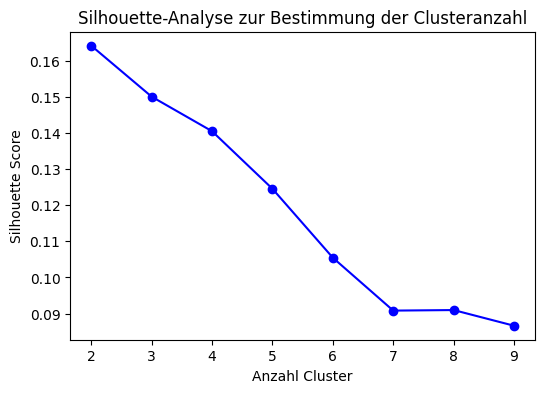

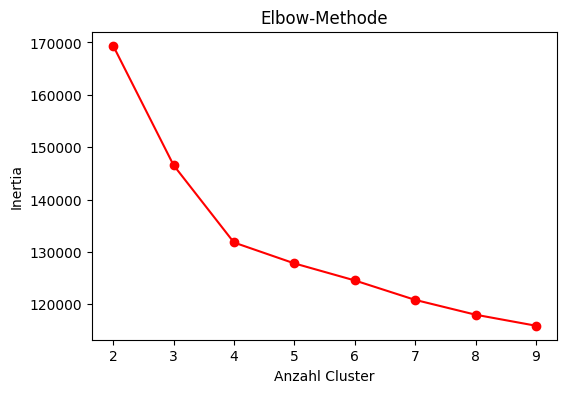

Optimale Clusteranzahl laut Silhouette: 2

=== Clusterqualität (hochdimensional) ===
Silhouette Score: 0.164
Calinski-Harabasz Score: 11083.113
Davies-Bouldin Score: 2.104

=== Vergleich mit Ground Truth (lung_cancer) ===
Adjusted Rand Index: 0.021
Adjusted Mutual Info: 0.018


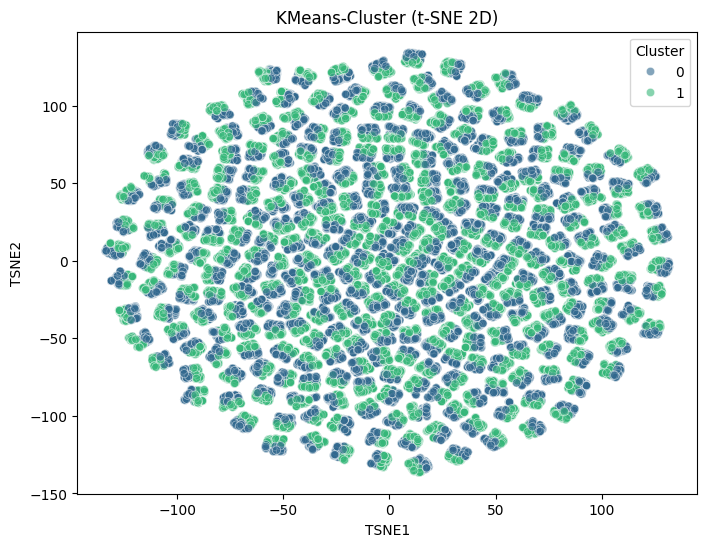

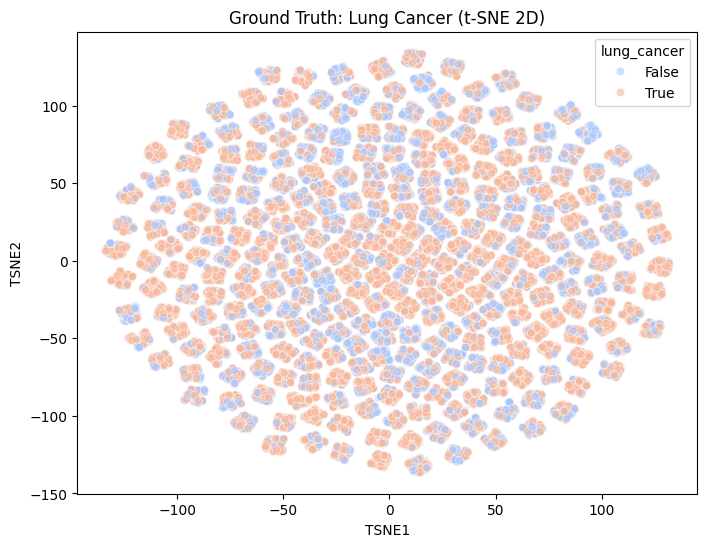

In [15]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

X_preproc = preprocessor.fit_transform(X)

# --- Optimale Clusteranzahl bestimmen ---
range_n_clusters = range(2, 10)
sil_scores = []
inertia_values = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_preproc)
    sil_scores.append(silhouette_score(X_preproc, cluster_labels))
    inertia_values.append(kmeans.inertia_)

# Silhouette Plot
plt.figure(figsize=(6,4))
plt.plot(range_n_clusters, sil_scores, 'o-', color='blue')
plt.xlabel("Anzahl Cluster")
plt.ylabel("Silhouette Score")
plt.title("Silhouette-Analyse zur Bestimmung der Clusteranzahl")
plt.show()

# Elbow-Methode
plt.figure(figsize=(6,4))
plt.plot(range_n_clusters, inertia_values, 'o-', color='red')
plt.xlabel("Anzahl Cluster")
plt.ylabel("Inertia")
plt.title("Elbow-Methode")
plt.show()

# Wähle die Clusteranzahl mit höchstem Silhouette-Score
optimal_clusters = range_n_clusters[sil_scores.index(max(sil_scores))]
print(f"Optimale Clusteranzahl laut Silhouette: {optimal_clusters}")

# --- KMeans mit optimaler Clusteranzahl ---
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(X_preproc)

# --- Clusterqualität im Hochdimensionalen Raum ---
sil_score = silhouette_score(X_preproc, clusters)
ch_score = calinski_harabasz_score(X_preproc, clusters)
db_score = davies_bouldin_score(X_preproc, clusters)

print("\n=== Clusterqualität (hochdimensional) ===")
print(f"Silhouette Score: {sil_score:.3f}")
print(f"Calinski-Harabasz Score: {ch_score:.3f}")
print(f"Davies-Bouldin Score: {db_score:.3f}")

# --- Vergleich Cluster vs. Ground Truth ---
ari = adjusted_rand_score(y, clusters)
ami = adjusted_mutual_info_score(y, clusters)

print("\n=== Vergleich mit Ground Truth (lung_cancer) ===")
print(f"Adjusted Rand Index: {ari:.3f}")
print(f"Adjusted Mutual Info: {ami:.3f}")

# --- t-SNE für Visualisierung ---
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_preproc)

plot_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
plot_df['Cluster'] = clusters
plot_df['lung_cancer'] = y.values

plt.figure(figsize=(8,6))
sns.scatterplot(data=plot_df, x='TSNE1', y='TSNE2', hue='Cluster', palette='viridis', alpha=0.6)
plt.title("KMeans-Cluster (t-SNE 2D)")
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(data=plot_df, x='TSNE1', y='TSNE2', hue='lung_cancer', palette='coolwarm', alpha=0.6)
plt.title("Ground Truth: Lung Cancer (t-SNE 2D)")
plt.show()